# Keras & Tensorflow multiclass classification
https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

In [1]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  
import cv2  

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_width, img_height = 224, 224  # image dimensions

top_model_weights_path = 'models/bottleneck_fc_model.h5'  # the top layer
train_data_dir = 'toy_data/train/'
validation_data_dir = 'toy_data/valid/'

epochs = 50
batch_size = 16

In [3]:
model = applications.VGG16(include_top=False, weights='imagenet')

In [4]:
datagen = ImageDataGenerator(rescale=1. / 255)  

generator = datagen.flow_from_directory(  
 train_data_dir,  
 target_size=(img_width, img_height),  
 batch_size=batch_size,  
 class_mode=None,  
 shuffle=False)  

nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  

predict_size_train = int(math.ceil(nb_train_samples / batch_size))  

bottleneck_features_train = model.predict_generator(  
 generator, predict_size_train, verbose=1)  

np.save('bottleneck_features_train.npy', bottleneck_features_train)  

generator = datagen.flow_from_directory(  
 validation_data_dir,  
 target_size=(img_width, img_height),  
 batch_size=batch_size,  
 class_mode=None,  
 shuffle=False)  

nb_validation_samples = len(generator.filenames)  

predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  

bottleneck_features_validation = model.predict_generator(  
 generator, predict_size_validation, verbose=1)  

np.save('bottleneck_features_validation.npy', bottleneck_features_validation)  

# labels for training data
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode='categorical',  
     shuffle=False)  

nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  

# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  

# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  

# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

# labels for validation features
generator_top = datagen_top.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  

nb_validation_samples = len(generator_top.filenames)  

validation_data = np.load('bottleneck_features_validation.npy')  

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 382 images belonging to 128 classes.
24/24 [==============================] - 100s 4s/step
Found 384 images belonging to 128 classes.
24/24 [==============================] - 99s 4s/step
Found 382 images belonging to 128 classes.
Found 384 images belonging to 128 classes.


# Create and train top model

In [5]:
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='sigmoid'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=epochs,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))  

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

Train on 382 samples, validate on 384 samples
Epoch 1/50
382/382 [==============================] - 2s 5ms/step - loss: 8.9256 - acc: 0.0105 - val_loss: 5.1796 - val_acc: 0.0104
Epoch 2/50
382/382 [==============================] - 2s 5ms/step - loss: 4.9227 - acc: 0.0445 - val_loss: 5.0972 - val_acc: 0.0052
Epoch 3/50
382/382 [==============================] - 2s 5ms/step - loss: 4.7780 - acc: 0.0550 - val_loss: 4.8797 - val_acc: 0.0234
Epoch 4/50
382/382 [==============================] - 2s 5ms/step - loss: 4.4009 - acc: 0.1126 - val_loss: 4.9569 - val_acc: 0.0417
Epoch 5/50
382/382 [==============================] - 2s 5ms/step - loss: 4.0140 - acc: 0.1597 - val_loss: 4.6351 - val_acc: 0.0729
Epoch 6/50
382/382 [==============================] - 2s 5ms/step - loss: 3.2314 - acc: 0.2932 - val_loss: 4.3855 - val_acc: 0.0911
Epoch 7/50
382/382 [==============================] - 2s 5ms/step - loss: 2.4966 - acc: 0.4084 - val_loss: 5.0765 - val_acc: 0.0938
Epoch 8/50
382/382 [==========

# Plot stuff

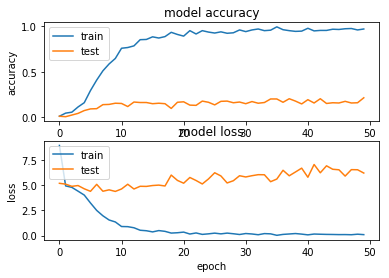

In [6]:
plt.figure(1)  

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 

# Prediction

In [7]:
def get_prediction(image_path):
    #print("[INFO] loading and preprocessing image...")  
    image = load_img(image_path, target_size=(224, 224))  
    image = img_to_array(image)  

    # important! otherwise the predictions will be '0'  
    image = image / 255  

    image = np.expand_dims(image, axis=0)  
    # run image through pipeline
    # build the VGG16 network  
    model = applications.VGG16(include_top=False, weights='imagenet')  

    # get the bottleneck prediction from the pre-trained VGG16 model  
    bottleneck_prediction = model.predict(image)  

    # build top model  
    model = Sequential()  
    model.add(Flatten(input_shape=bottleneck_prediction.shape[1:]))  
    model.add(Dense(256, activation='relu'))  
    model.add(Dropout(0.5))  
    model.add(Dense(num_classes, activation='sigmoid'))  

    model.load_weights(top_model_weights_path)  

    # use the bottleneck prediction on the top model to get the final classification  
    class_predicted = model.predict_classes(bottleneck_prediction) 

    inID = class_predicted[0]  

    class_dictionary = generator_top.class_indices  

    inv_map = {v: k for k, v in class_dictionary.items()}  

    label = inv_map[inID]  
    return label

In [16]:
# Kaggle submission
import json
from tqdm import tnrange, tqdm_notebook
from tqdm import tqdm

json_data = json.load(open('kaggle/test.json'))
test_dir = 'data/test/'

ids = []
predicted_labels = []

for i in tqdm_notebook(json_data['images']):
    pred = get_prediction(test_dir + str(i['image_id']) + '.jpg')
    ids.append(i['image_id'])
    predicted_labels.append(pred)

A Jupyter Widget

KeyboardInterrupt: 

In [17]:
import pandas as pd
import datetime

my_submission = pd.DataFrame({'id': ids, 'predicted': predicted_labels})
file_name = 'submission_' + str(datetime.datetime.now()) +'.csv'
my_submission.to_csv(file_name, index=False)